In [3]:
import numpy as np
import json
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import time
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from IPython.display import display, clear_output

In [4]:
def is_winner(player):
    """
    Checks if player has won
    """
    if player is not None:
        win_set = [{0,1,2},{3,4,5},{6,7,8},{0,4,8},{0,3,6},{1,4,7},{2,4,6},{2,5,8}]
        for a in win_set:
            if player.issuperset(a):
                return a
        else:
            return False
    return False
    
def is_entry(cb,md):
    """
    Load entry from move dictionary else create one
    """
    # is there an entry?
    if cb in md: 
        prob = md[cb]
    else: # if no
        #create a new entry
        prob = np.array([[1,1] if cb[i]=='E' else 0 for i in range(9) ])
        md[cb] = prob
    return (prob,md)

def make_move(prob_dist,cb):
    """
    Makes a move based on the probability distribution
    """
    #find all empty indexes
    ind = findi(cb,'E')
    #determine who's playing then check to see if there are any winning moves
    nu_O = cb.count('O')
    nu_X = cb.count('X')
    
    if nu_X>nu_O: #it's O's turn
        #check if cell will win game
        for cell in ind:
            moves = set(findi(cb,'O'))
            moves.add(cell)
            if is_winner(moves) is not False:
                return cell
        #else check if cell will prevent loss of game
        for cell in ind:
            moves = set(findi(cb,'X'))
            moves.add(cell)
            if is_winner(moves) is not False:
                return cell  
    else: #it's X's turn
        #check if cell will win game
        for cell in ind:
            moves = set(findi(cb,'X'))
            moves.add(cell)
            if is_winner(moves) is not False:
                return cell
        #else check if cell will prevent loss of game
        for cell in ind:
            moves = set(findi(cb,'O'))
            moves.add(cell)
            if is_winner(moves) is not False:
                return cell        
    
    ps = np.zeros(9)
    for i in ind:
        ps[i] = stats.beta.rvs(prob_dist[i][0],prob_dist[i][0],0,1,1)[0]
    return ps.argmax()

def findi(s, ch):
    """
    finds all indicies of chr in string s
    """
    return [i for i, ltr in enumerate(s) if ltr == ch]

def play_token(current_board,i,player_no=1):
    """
    Update gameboard based on current play
    """
    #update gameboard
    if player_no == 1:
        cboard = current_board[:i] + 'X' + current_board[(i+1):]
    else:    
        cboard = current_board[:i] + 'O' + current_board[(i+1):]
    return cboard

def update_dict(mdict,pmoves,wt = 1):
    """
    updates the move_dict based on the players moves (that led to a win)
    """
    for board,cell in pmoves.items():
        #get current prob
        p = mdict[board]
        #improve cell
        if wt == 1: #if a positive result
            p[cell][0] = p[cell][0] + 1
        else:
            p[cell][1] = p[cell][1] + 1
        mdict[board] = p
    return mdict
        

def show_game(board,fig,ax):
    """
    Plots the board, returns boolean when game ends
    """
    over = False

    #set up the plot space
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(0.5,3.5)
    ax.axhline(1.5,color='grey')
    ax.axhline(2.5,color='grey')
    ax.axvline(1.5,color='grey')
    ax.axvline(2.5,color='grey')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    

    
    play_x = set(findi(board,'X'))
    play_o = set(findi(board,'O'))
    cel_coord = {0:(1,3),1:(2,3),2:(3,3),3:(1,2),4:(2,2),5:(3,2),6:(1,1),7:(2,1),8:(3,1)}
    for i in play_x:
        ax.plot(cel_coord[i][0],cel_coord[i][1],'kX',markersize=52)
        
        #check if winner yet
        if is_winner(play_x):
            winning_set = is_winner(play_x)
            pnt1 = -1
            pnt2 = -1
            for pnt in winning_set:
                if (pnt1==-1)&(pnt2==-1):
                    pnt1 = pnt
                else:
                    pnt2 = copy.deepcopy(pnt1)
                    pnt1 = pnt
                    ax.plot([cel_coord[pnt1][0],cel_coord[pnt2][0]],[cel_coord[pnt1][1],cel_coord[pnt2][1]],'g-',\
                            linewidth=4)
            over = True
    for i in play_o:
        ax.plot(cel_coord[i][0],cel_coord[i][1],'ro',markeredgewidth=20,markerfacecolor='w',markersize=52)
        
        #check if winner yet
        if is_winner(play_o):
            winning_set = is_winner(play_o)
            pnt1 = -1
            pnt2 = -1
            for pnt in winning_set:
                if (pnt1==-1)&(pnt2==-1):
                    pnt1 = pnt
                else:
                    pnt2 = copy.deepcopy(pnt1)
                    pnt1 = pnt
                    ax.plot([cel_coord[pnt1][0],cel_coord[pnt2][0]],[cel_coord[pnt1][1],cel_coord[pnt2][1]],'g-',\
                            linewidth=4)
            over = True
    display(fig)
    clear_output(wait = True)
    return over

def write_dict(filename,mdict):
    """
    Stores the move dictionary
    """
    output_dict = {}
    for k,v in mdict.items():
        cell_dict = {}
        for c,cell in enumerate(v):
            if type(cell)==int:
                cell_dict[c]={'alpha':0,'beta':0}
            else:
                cell_dict[c]={'alpha':int(cell[0]),'beta':int(cell[1])}
        output_dict[k] = cell_dict
    with open(filename, 'w') as outfile:
        json.dump(output_dict, outfile)
    print('Complete')
    pass
def read_dict(filename):
    """
    Reads a saved move dictionary
    """
    mdict = {}
    with open(filename) as json_file:
        data = json.load(json_file)
        for k,v in data.items():
            mdict[k] = np.array([[v[str(i)]['alpha'],v[str(i)]['beta']] if v[str(i)]['alpha']>0 else 0 for i in range(9)])
    return mdict

In [5]:
max_ind = {}
win_log = []

for trial in range(1):

    move_dict = {}

    # #set up the plot
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(111)

    #play n_games
    for n_games in range(100000):

        cboard = 'EEEEEEEEE' #initial board

        #set up the player_moves
        ply1_moves = {}
        ply2_moves = {}

        for move in range(9):
            if (move%2) == 0:
                player = 1
            else:
                player = 2

            #load probability
            (prob,move_dict) = is_entry(cboard,move_dict)
            #make a selection
            i = make_move(prob,cboard)

            #save selection
            if player==1:
                ply1_moves[cboard] = i
            else:
                ply2_moves[cboard] = i  
            #make move
            cboard = play_token(cboard,i,player)
            #check if there's a winner
            if is_winner(set(findi(cboard,'X'))):
                break
            if is_winner(set(findi(cboard,'O'))):
                break 
    #         if show_game(cboard,fig,ax):
    #             break
    #         time.sleep(.1)

        #was there a winner?
        if is_winner(set(findi(cboard,'X'))):
            #player 1 wins
            #print('Player 1 Wins game %d'%n_games)
            move_dict = update_dict(move_dict,ply1_moves,1)
            move_dict = update_dict(move_dict,ply2_moves,0)
            win_log.append('X')
        elif is_winner(set(findi(cboard,'O'))):
            #player 2 wins
            #print('Player 2 Wins game %d'%n_games)
            move_dict = update_dict(move_dict,ply2_moves,1)
            move_dict = update_dict(move_dict,ply1_moves,0)
            win_log.append('O')
        else:
            #ties are better than a lose
            move_dict = update_dict(move_dict,ply1_moves,1)
            move_dict = update_dict(move_dict,ply2_moves,1)
            win_log.append('T')
        if (n_games%10000)==0:
            print("%d games played."%n_games)
print('Complete')
write_dict("bayes%s_b.json"%(str(n_games+1)),move_dict)

0 games played.
10000 games played.
20000 games played.
30000 games played.
40000 games played.
50000 games played.
60000 games played.
70000 games played.
80000 games played.
90000 games played.
Complete
Complete


In [6]:
cnts = [Counter(win_log[(1000*r):(1000*(r+1))])for r in range(0,int((n_games+1)/1000))]

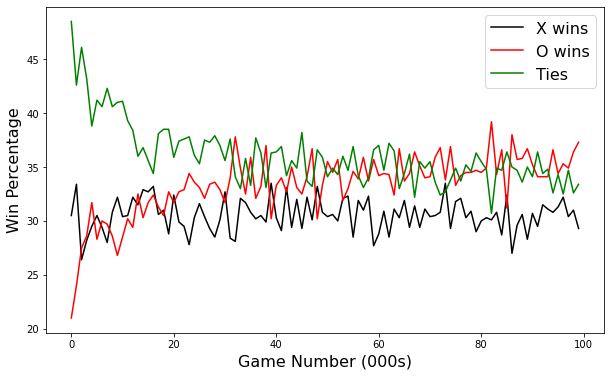

In [7]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.array([cnts[i]['X'] for i in range(len(cnts))])/10,'k-',label="X wins")
plt.plot(np.array([cnts[i]['O'] for i in range(len(cnts))])/10,'r-',label="O wins")
plt.plot(np.array([cnts[i]['T'] for i in range(len(cnts))])/10,'g-',label="Ties")
plt.xlabel('Game Number (000s)',fontsize=16)
plt.ylabel('Win Percentage',fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [38]:
move_dict = read_dict("bayes100000_b.json")
cb = 'EEXXEOEOE'
r = move_dict[cb]
r

array([list([19, 1]), list([19, 1]), 0, 0, list([17, 1]), 0,
       list([17, 1]), 0, list([21, 1])], dtype=object)

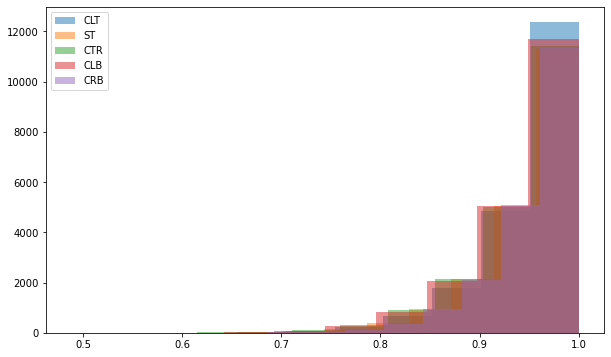

In [36]:
fig = plt.figure(figsize=(10,6))
cell_dict = {0:'CLT',1:'ST',2:'CRT',3:'SL',4:'CTR',5:'SR',6:'CLB',7:'SB',8:'CRB'}
for i in findi(cb,'E'):
    sts = stats.beta.rvs(r[i][0],r[i][1],0,1,20000)
    plt.hist(sts,label=cell_dict[i],alpha = 0.5)
    plt.legend()
    

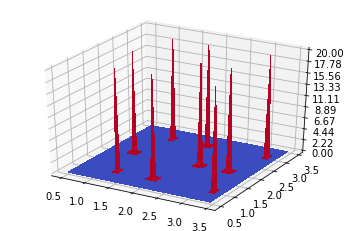

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(.5, 3.5, 0.05)
Y = np.arange(.5, 3.5, 0.05)
X, Y = np.meshgrid(X, Y)
Z = np.zeros(X.shape)
for i in range(9):
    if r[i][0]:
        [f,b] = np.histogram(stats.beta.rvs(r[i][0],r[i][1],0,1,20000),bins=(np.arange(.5, 1.5, 0.05)-.5),density=True)
        Z[(10+int(i/3)*20),((i%3)*20):(19+(i%3)*20)] = f
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

False

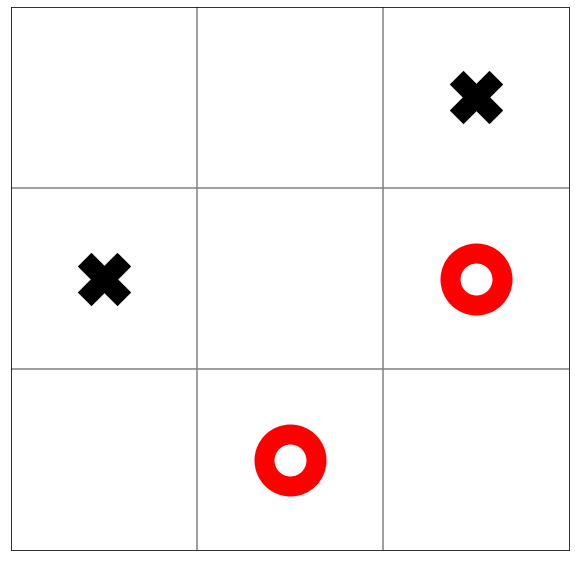

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
show_game(cb,fig,ax)

Complete


In [29]:
move_dict.keys()

dict_keys(['EEEEEEEEE', 'XEEEEEEEE', 'XOEEEEEEE', 'XOEEEEEXE', 'XOEOEEEXE', 'XOXOEEEXE', 'XOXOEOEXE', 'XOXOXOEXE', 'XOXOXOOXE', 'EEEXEEEEE', 'EEEXEOEEE', 'EEXXEOEEE', 'OEXXEOEEE', 'OEXXXOEEE', 'OEXXXOOEE', 'OXXXXOOEE', 'OXXXXOOOE', 'EEEEEEEEX', 'EOEEEEEEX', 'EOEEEXEEX', 'EOOEEXEEX', 'XOOEEXEEX', 'XOOEOXEEX', 'XOOEOXXEX', 'EEEEEXEEE', 'EEEEOXEEE', 'EEEEOXEXE', 'OEEEOXEXE', 'OEEEOXEXX', 'OEOEOXEXX', 'EEEEEXEEO', 'XEEEEXEEO', 'XEEOEXEEO', 'XEEOXXEEO', 'XEOOXXEEO', 'XEOOXXXEO', 'XEOOXXXOO', 'EEEEXEEEE', 'EEEEXEEEO', 'EXEEXEEEO', 'EXEEXEEOO', 'EXEEXEXOO', 'EXOEXEXOO', 'EXOEXXXOO', 'EXOOXXXOO', 'EEEEEEOEX', 'EEEXEEOEX', 'EEEXEOOEX', 'EEEXXOOEX', 'OEEXXOOEX', 'OXEXXOOEX', 'OXEXXOOOX', 'EXEEEEEEE', 'EXEOEEEEE', 'EXEOEEXEE', 'EXEOEEXEO', 'EXEOXEXEO', 'EXOOXEXEO', 'EEEEOEEEX', 'EEEEOXEEX', 'EEOEOXEEX', 'EEOEOXXEX', 'EEOEOXXOX', 'EXOEOXXOX', 'EXOOOXXOX', 'EXEEEOEEE', 'XXEEEOEEE', 'XXOEEOEEE', 'XXOEEOEEX', 'XXOEOOEEX', 'XXOXOOEEX', 'EXEEEEEOE', 'EXEEEXEOE', 'OXEEEXEOE', 'OXEEEXXOE', 'OXEEOXXOE', '